## SETTING

In [ ]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

import random
import torch
import torch.nn.functional as F

In [ ]:
from google import colab
colab.drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# go to file
os.chdir('/content/drive/MyDrive/김유민/DAB')

## 전처리

1) duaration = 10번 주기 위해 사이즈별 날짜마다 10번 행 반복

2) duration기준으로 1일전, 2일전 ,,,, 10일전 mean, min, max 가져오기

3) targetprice는 각 사이즈의 해당 날짜 내 평균 값. 1개 값으로 고정 !!

4) 신발사이즈 revise나 240(us.머시기) 같은거 사이즈 숫자기준으로 다 통일 -> 문자로 취급

5) 날짜 파생변수 만들기 - diff_price, diff_date, year, month, day, weekend

6) train, test 날짜 제대로 체크 (3/30 ~ 7/2까지)

7) 신발 정보 매칭하기, size까지해서 범주형으로 취급

In [ ]:
shoe1 = pd.read_csv("/content/drive/Shareddrives/DAB 경진대회/모델링/유민/shoe_cleansing/shoe1.csv")
shoe1.columns = ['date','size','price','name','brand','transaction_t', 'scrab','likes','releaseDate', 'color','releasePrice']
shoe1 = shoe1.sort_values(by=['size','date'])

In [ ]:
data = shoe1.groupby(['size','date']).count() #동일 size내에서 date구분!!
data.sort_values(by = ['size','date']).reset_index(drop=True)
data["todaycount"] =  data["price"] #각 size내 date별로 거래량 카운트
data = data[["todaycount"]]
data = data.reset_index().rename(columns={"index": "id"})

In [ ]:
data

,size,date,todaycount
0,220,2022-03-30,1
1,220,2022-03-31,15
2,220,2022-04-01,21
3,220,2022-04-02,11
4,220,2022-04-03,15
...,...,...,...
753,280,2022-05-06,2
754,280,2022-05-08,2
755,280,2022-05-10,1
756,280,2022-06-02,2


In [ ]:
groups = shoe1.groupby(['size','date'])
groupmean = groups.mean()['price']
groupmin = groups.min()['price']
groupmax = groups.max()['price']

groupdata = pd.DataFrame([groupmean, groupmin, groupmax]).transpose()
groupdata.columns=['mean', 'min', 'max']

In [ ]:
groupdata

mean       min       max
size date                                         
220  2022-03-30  162000.000000  162000.0  162000.0
     2022-03-31  158466.666667  155000.0  160000.0
     2022-04-01  153476.190476  148000.0  158000.0
     2022-04-02  160818.181818  159000.0  162000.0
     2022-04-03  160133.333333  156000.0  162000.0
...                        ...       ...       ...
280  2022-05-06  173500.000000  170000.0  177000.0
     2022-05-08  187500.000000  185000.0  190000.0
     2022-05-10  200000.000000  200000.0  200000.0
     2022-06-02  187500.000000  165000.0  210000.0
285  2022-04-09  140000.000000  140000.0  140000.0

[758 rows x 3 columns]

In [ ]:
data['mean'] = groupdata['mean'].values #합쳐주기
data['min'] = groupdata['min'].values
data['max'] = groupdata['max'].values
data['cumcount'] = [i for i in range(len(data))]
cumtrans = []
for i in range(len(data)):
    if i== 0 : cumtrans.append(data.iloc[i, 2])
    else:
      cumtrans.append(cumtrans[i-1]+data.iloc[i,2])

data['cumtrans'] = cumtrans

In [ ]:
data

,size,date,todaycount,mean,min,max,cumcount,cumtrans
0,220,2022-03-30,1,162000.000000,162000.0,162000.0,0,1
1,220,2022-03-31,15,158466.666667,155000.0,160000.0,1,16
2,220,2022-04-01,21,153476.190476,148000.0,158000.0,2,37
3,220,2022-04-02,11,160818.181818,159000.0,162000.0,3,48
4,220,2022-04-03,15,160133.333333,156000.0,162000.0,4,63
...,...,...,...,...,...,...,...,...
753,280,2022-05-06,2,173500.000000,170000.0,177000.0,753,13137
754,280,2022-05-08,2,187500.000000,185000.0,190000.0,754,13139
755,280,2022-05-10,1,200000.000000,200000.0,200000.0,755,13140
756,280,2022-06-02,2,187500.000000,165000.0,210000.0,756,13142


In [ ]:
duration = [] #일단 각 행을 10번 늘리기 체크 -> 참고로 나중에 duaration=0인거 빼줘야함

newdata = data.copy()
for i in tqdm(range(len(data))):
    duration.append(0)
    for j in range(10):
      newdata = newdata.append(data.loc[i])
      duration.append(j+1)

newdata = newdata.sort_values(by = ['size','date']).reset_index(drop=True)
newdata['duration'] = duration
newdata #지금 그러면 대략 758행x11번 행 개수만큼 나옴

100%|██████████| 758/758 [00:31<00:00, 24.21it/s]


,size,date,todaycount,mean,min,max,cumcount,cumtrans,duration
0,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,0
1,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,1
2,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,2
3,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,3
4,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,4
...,...,...,...,...,...,...,...,...,...
8333,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,6
8334,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,7
8335,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,8
8336,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,9


In [ ]:
newdata #지금 그러면 대략 757행x11번 행 개수만큼 나옴

,size,date,todaycount,mean,min,max,cumcount,cumtrans,duration
0,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,0
1,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,1
2,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,2
3,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,3
4,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,4
...,...,...,...,...,...,...,...,...,...
8333,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,6
8334,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,7
8335,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,8
8336,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,9


In [ ]:
#targetprice는 신발별 해당 날짜의 평균으로 고정
#한 날짜별로 (target)price가 하나여야지, 여러개면 말이 안됨..
newdata['targetprice'] = newdata['mean'] 

In [ ]:
#해당 사이즈&날짜에서 1,2,3,,10(=duration)일 전 mean, min, max값 가져오기
duration = []
lastmean = []
lastmin = []
lastmax = []

newdata = data.copy()
for i in tqdm(range(len(data))):
    duration.append(0)
    lastmean.append(data.iloc[i,3])
    lastmin.append(data.iloc[i,4])
    lastmax.append(data.iloc[i,5])
    for j in range(10):  
      newdata = newdata.append(data.loc[i])
      duration.append(j+1)
      try:
        lastmean.append(data.iloc[i-j-1,3])  #1,2,3,,, 전 mean값 가져오기
        lastmin.append(data.iloc[i-j-1,4])
        lastmax.append(data.iloc[i-j-1,5])
      except:
        lastmean.append(-1)
        lastmin.append(-1)
        lastmax.append(-1)

newdata = newdata.sort_values(by = ['size','date']).reset_index(drop=True)
newdata['duration'] = duration
newdata['lastmean'] = lastmean
newdata['lastmin'] = lastmin
newdata['lastmax'] = lastmax

newdata

100%|██████████| 758/758 [00:31<00:00, 23.98it/s]


,size,date,todaycount,mean,min,max,cumcount,cumtrans,duration,lastmean,lastmin,lastmax
0,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,0,162000.0,162000.0,162000.0
1,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,1,140000.0,140000.0,140000.0
2,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,2,187500.0,165000.0,210000.0
3,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,3,200000.0,200000.0,200000.0
4,220,2022-03-30,1,162000.0,162000.0,162000.0,0,1,4,187500.0,185000.0,190000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8333,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,6,190000.0,190000.0,190000.0
8334,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,7,180000.0,180000.0,180000.0
8335,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,8,179000.0,179000.0,179000.0
8336,285,2022-04-09,1,140000.0,140000.0,140000.0,757,13143,9,179000.0,179000.0,179000.0


In [ ]:
#이제 1) 초반날짜라 2,3,4,,10일 전만큼 참고할 게 없는 행 2) duartion이 0 인 행 => 삭제

In [ ]:
index1 = newdata[(newdata['date'] == '2022-03-30') & ((newdata['duration'] ==1) |(newdata['duration'] ==2) |(newdata['duration'] ==3)|(newdata['duration'] ==4)|(newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index2 = newdata[(newdata['date'] == '2022-03-31') & ((newdata['duration'] ==2) |(newdata['duration'] ==3)|(newdata['duration'] ==4)|(newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index3 = newdata[(newdata['date'] == '2022-04-01') & ((newdata['duration'] ==3)|(newdata['duration'] ==4)|(newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index4 = newdata[(newdata['date'] == '2022-04-02') & ((newdata['duration'] ==4)|(newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index5 = newdata[(newdata['date'] == '2022-04-03') & ((newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index6 = newdata[(newdata['date'] == '2022-04-04') & ((newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index7 = newdata[(newdata['date'] == '2022-04-05') & ((newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index8 = newdata[(newdata['date'] == '2022-04-06') & ((newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index9 = newdata[(newdata['date'] == '2022-04-07') & ((newdata['duration'] ==9)|(newdata['duration'] ==10))]
index10 = newdata[(newdata['date'] == '2022-04-08') & (newdata['duration'] ==10)]

In [ ]:
newdata = newdata.drop(index1.index)
newdata = newdata.drop(index2.index)
newdata = newdata.drop(index3.index)
newdata = newdata.drop(index4.index)
newdata = newdata.drop(index5.index)
newdata = newdata.drop(index6.index)
newdata = newdata.drop(index7.index)
newdata = newdata.drop(index8.index)
newdata = newdata.drop(index9.index)
newdata = newdata.drop(index10.index).reset_index(drop=True)

In [ ]:
newdata = newdata.loc[newdata['duration']!=0,:]
newdata = newdata.reset_index(drop=True)
newdata

,size,date,todaycount,mean,min,max,cumcount,cumtrans,duration,lastmean,lastmin,lastmax,targetprice
0,220,2022-03-31,15,158466.666667,155000.0,160000.0,1,16,1,162000.000000,162000.0,162000.0,158466.666667
1,220,2022-04-01,21,153476.190476,148000.0,158000.0,2,37,1,158466.666667,155000.0,160000.0,153476.190476
2,220,2022-04-01,21,153476.190476,148000.0,158000.0,2,37,2,162000.000000,162000.0,162000.0,153476.190476
3,220,2022-04-02,11,160818.181818,159000.0,162000.0,3,48,1,153476.190476,148000.0,158000.0,160818.181818
4,220,2022-04-02,11,160818.181818,159000.0,162000.0,3,48,2,158466.666667,155000.0,160000.0,160818.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,285,2022-04-09,1,140000.000000,140000.0,140000.0,757,13143,6,190000.000000,190000.0,190000.0,140000.000000
7286,285,2022-04-09,1,140000.000000,140000.0,140000.0,757,13143,7,180000.000000,180000.0,180000.0,140000.000000
7287,285,2022-04-09,1,140000.000000,140000.0,140000.0,757,13143,8,179000.000000,179000.0,179000.0,140000.000000
7288,285,2022-04-09,1,140000.000000,140000.0,140000.0,757,13143,9,179000.000000,179000.0,179000.0,140000.000000


In [ ]:
# 기존에 mean, min, max열 삭제해주기
newdata['targetprice'] = newdata['mean'] 
newdata = newdata.drop(['mean','min','max'], axis=1)

In [ ]:
#스니커즈 정보 불러오기
newdata['name'] = shoe1['name'][0]
newdata['brand'] = shoe1['brand'][0]
newdata['transaction_t'] = shoe1['transaction_t'][0]
newdata['scrab'] = shoe1['likes'][0]
newdata['color'] = shoe1['color'][0]
newdata['releaseDate'] = shoe1['releaseDate'][0]
newdata['releasePrice'] = shoe1['releasePrice'][0]
#newdata['releasePrice'] = newdata['releasePrice'].str.replace(",", "", )
#newdata['releasePrice'] = newdata['releasePrice'].astype(int)

#날짜 파생변수 만들기 - diff_price, diff_date, year, month, day, weekend
newdata['diff_price'] = newdata['lastmean'] - newdata['releasePrice']
newdata['date'] = pd.to_datetime(newdata['date'], format = '%Y-%m-%d')
newdata['releaseDate'] = shoe1['releaseDate'][0]
newdata['releaseDate'] = pd.to_datetime(newdata['releaseDate'], format = '%Y-%m-%d')
newdata['diff_date'] = newdata['date']-newdata['releaseDate']
newdata['diff_date'] =newdata['diff_date'].dt.days 
newdata['date'] = newdata['date'].astype(str)
newdata[['year','month', 'day']] = newdata['date'].str.split('-', expand=True)
newdata['weekend'] = pd.to_datetime(newdata['date'],yearfirst=True).dt.dayofweek>4

newdata['month']=newdata['month'].astype(int)
newdata['day']=newdata['day'].astype(int)

In [ ]:
new1 = newdata.copy()

In [ ]:
new1

,size,date,todaycount,cumcount,cumtrans,duration,lastmean,lastmin,lastmax,targetprice,...,scrab,color,releaseDate,releasePrice,diff_price,diff_date,year,month,day,weekend
0,220,2022-03-31,15,1,16,1,162000.000000,162000.0,162000.0,158466.666667,...,880,WHITE,2019-01-02,129000,33000.000000,1184,2022,03,31,False
1,220,2022-04-01,21,2,37,1,158466.666667,155000.0,160000.0,153476.190476,...,880,WHITE,2019-01-02,129000,29466.666667,1185,2022,04,01,False
2,220,2022-04-01,21,2,37,2,162000.000000,162000.0,162000.0,153476.190476,...,880,WHITE,2019-01-02,129000,33000.000000,1185,2022,04,01,False
3,220,2022-04-02,11,3,48,1,153476.190476,148000.0,158000.0,160818.181818,...,880,WHITE,2019-01-02,129000,24476.190476,1186,2022,04,02,True
4,220,2022-04-02,11,3,48,2,158466.666667,155000.0,160000.0,160818.181818,...,880,WHITE,2019-01-02,129000,29466.666667,1186,2022,04,02,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,285,2022-04-09,1,757,13143,6,190000.000000,190000.0,190000.0,140000.000000,...,880,WHITE,2019-01-02,129000,61000.000000,1193,2022,04,09,True
7286,285,2022-04-09,1,757,13143,7,180000.000000,180000.0,180000.0,140000.000000,...,880,WHITE,2019-01-02,129000,51000.000000,1193,2022,04,09,True
7287,285,2022-04-09,1,757,13143,8,179000.000000,179000.0,179000.0,140000.000000,...,880,WHITE,2019-01-02,129000,50000.000000,1193,2022,04,09,True
7288,285,2022-04-09,1,757,13143,9,179000.000000,179000.0,179000.0,140000.000000,...,880,WHITE,2019-01-02,129000,50000.000000,1193,2022,04,09,True


### 반복

In [ ]:
shoe1 = pd.read_csv("/content/drive/Shareddrives/DAB 경진대회/모델링/유민/shoe_cleansing/shoe13.csv")
shoe1.columns = ['date','size','price','name','brand','transaction_t', 'scrab','likes','releaseDate', 'color','releasePrice']
shoe1 = shoe1.sort_values(by=['size','date'])

In [ ]:
data = shoe1.groupby(['size','date']).count() #동일 size내에서 date구분!!
data.sort_values(by = ['size','date']).reset_index(drop=True)
data["todaycount"] =  data["price"] #각 size내 date별로 거래량 카운트
data = data[["todaycount"]]
data = data.reset_index().rename(columns={"index": "id"})

In [ ]:
groups = shoe1.groupby(['size','date'])
groupmean = groups.mean()['price']
groupmin = groups.min()['price']
groupmax = groups.max()['price']

groupdata = pd.DataFrame([groupmean, groupmin, groupmax]).transpose()
groupdata.columns=['mean', 'min', 'max']

In [ ]:
data['mean'] = groupdata['mean'].values #합쳐주기
data['min'] = groupdata['min'].values
data['max'] = groupdata['max'].values
data['cumcount'] = [i for i in range(len(data))]
cumtrans = []
for i in range(len(data)):
    if i== 0 : cumtrans.append(data.iloc[i, 2])
    else:
      cumtrans.append(cumtrans[i-1]+data.iloc[i,2])

data['cumtrans'] = cumtrans

In [ ]:
#해당 날짜에서 1,2,3,,10(=duration)일 전 mean, min, max값 가져오기
duration = []
lastmean = []
lastmin = []
lastmax = []

newdata = data.copy()
for i in tqdm(range(len(data))):
    duration.append(0)
    lastmean.append(data.iloc[i,3])
    lastmin.append(data.iloc[i,4])
    lastmax.append(data.iloc[i,5])
    for j in range(10):  
      newdata = newdata.append(data.loc[i])
      duration.append(j+1)
      try:
        lastmean.append(data.iloc[i-j-1,3])  #1,2,3,,, 전 mean값 가져오기
        lastmin.append(data.iloc[i-j-1,4])
        lastmax.append(data.iloc[i-j-1,5])
      except:
        lastmean.append(-1)
        lastmin.append(-1)
        lastmax.append(-1)

newdata = newdata.sort_values(by = ['size','date']).reset_index(drop=True)
newdata['duration'] = duration
newdata['lastmean'] = lastmean
newdata['lastmin'] = lastmin
newdata['lastmax'] = lastmax

newdata

100%|██████████| 120/120 [00:04<00:00, 25.03it/s]


,size,date,todaycount,mean,min,max,cumcount,cumtrans,duration,lastmean,lastmin,lastmax
0,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,0,6.500000e+05,650000.0,650000.0
1,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,1,7.900000e+05,790000.0,790000.0
2,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,2,1.009000e+06,1009000.0,1009000.0
3,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,3,8.900000e+05,890000.0,890000.0
4,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,4,9.800000e+05,980000.0,980000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1315,305,2022-07-01,1,790000.0,790000.0,790000.0,119,414,6,9.000000e+05,900000.0,900000.0
1316,305,2022-07-01,1,790000.0,790000.0,790000.0,119,414,7,8.350000e+05,810000.0,860000.0
1317,305,2022-07-01,1,790000.0,790000.0,790000.0,119,414,8,9.385000e+05,927000.0,950000.0
1318,305,2022-07-01,1,790000.0,790000.0,790000.0,119,414,9,9.635000e+05,910000.0,1090000.0


In [ ]:
index1 = newdata[(newdata['date'] == '2022-03-30') & ((newdata['duration'] ==1) |(newdata['duration'] ==2) |(newdata['duration'] ==3)|(newdata['duration'] ==4)|(newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index2 = newdata[(newdata['date'] == '2022-03-31') & ((newdata['duration'] ==2) |(newdata['duration'] ==3)|(newdata['duration'] ==4)|(newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index3 = newdata[(newdata['date'] == '2022-04-01') & ((newdata['duration'] ==3)|(newdata['duration'] ==4)|(newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index4 = newdata[(newdata['date'] == '2022-04-02') & ((newdata['duration'] ==4)|(newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index5 = newdata[(newdata['date'] == '2022-04-03') & ((newdata['duration'] ==5)|(newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index6 = newdata[(newdata['date'] == '2022-04-04') & ((newdata['duration'] ==6)|(newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index7 = newdata[(newdata['date'] == '2022-04-05') & ((newdata['duration'] ==7)|(newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index8 = newdata[(newdata['date'] == '2022-04-06') & ((newdata['duration'] ==8)|(newdata['duration'] ==9)|(newdata['duration'] ==10))]
index9 = newdata[(newdata['date'] == '2022-04-07') & ((newdata['duration'] ==9)|(newdata['duration'] ==10))]
index10 = newdata[(newdata['date'] == '2022-04-08') & (newdata['duration'] ==10)]

In [ ]:
newdata = newdata.drop(index1.index)
newdata = newdata.drop(index2.index)
newdata = newdata.drop(index3.index)
newdata = newdata.drop(index4.index)
newdata = newdata.drop(index5.index)
newdata = newdata.drop(index6.index)
newdata = newdata.drop(index7.index)
newdata = newdata.drop(index8.index)
newdata = newdata.drop(index9.index)
newdata = newdata.drop(index10.index).reset_index(drop=True)

In [ ]:
newdata = newdata.loc[newdata['duration']!=0,:]
newdata = newdata.reset_index(drop=True)
newdata

,size,date,todaycount,mean,min,max,cumcount,cumtrans,duration,lastmean,lastmin,lastmax
0,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,1,7.900000e+05,790000.0,790000.0
1,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,2,1.009000e+06,1009000.0,1009000.0
2,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,3,8.900000e+05,890000.0,890000.0
3,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,4,9.800000e+05,980000.0,980000.0
4,225,2022-06-30,1,650000.0,650000.0,650000.0,0,1,5,8.750000e+05,850000.0,900000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,305,2022-07-01,1,790000.0,790000.0,790000.0,119,414,6,9.000000e+05,900000.0,900000.0
1196,305,2022-07-01,1,790000.0,790000.0,790000.0,119,414,7,8.350000e+05,810000.0,860000.0
1197,305,2022-07-01,1,790000.0,790000.0,790000.0,119,414,8,9.385000e+05,927000.0,950000.0
1198,305,2022-07-01,1,790000.0,790000.0,790000.0,119,414,9,9.635000e+05,910000.0,1090000.0


In [ ]:
# 기존에 mean, min, max열 삭제해주기
newdata['targetprice'] = newdata['mean'] 
newdata = newdata.drop(['mean','min','max'], axis=1)

In [ ]:
#스니커즈 정보 불러오기
newdata['name'] = shoe1['name'][0]
newdata['brand'] = shoe1['brand'][0]
newdata['transaction_t'] = shoe1['transaction_t'][0]
newdata['scrab'] = shoe1['likes'][0]
newdata['color'] = shoe1['color'][0]
newdata['releaseDate'] = shoe1['releaseDate'][0]
newdata['releasePrice'] = shoe1['releasePrice'][0]
#newdata['releasePrice'] = newdata['releasePrice'].str.replace(",", "", )
#newdata['releasePrice'] = newdata['releasePrice'].astype(int)

#날짜 파생변수 만들기 - diff_price, diff_date, year, month, day, weekend
newdata['diff_price'] = newdata['lastmean'] - newdata['releasePrice']
newdata['date'] = pd.to_datetime(newdata['date'], format = '%Y-%m-%d')
newdata['releaseDate'] = shoe1['releaseDate'][0]
newdata['releaseDate'] = pd.to_datetime(newdata['releaseDate'], format = '%Y-%m-%d')
newdata['diff_date'] = newdata['date']-newdata['releaseDate']
newdata['diff_date'] =newdata['diff_date'].dt.days 
newdata['date'] = newdata['date'].astype(str)
newdata[['year','month', 'day']] = newdata['date'].str.split('-', expand=True)
newdata['weekend'] = pd.to_datetime(newdata['date'],yearfirst=True).dt.dayofweek>4

In [ ]:
new13 = newdata.copy()

In [ ]:
new11

In [ ]:
combine = pd.concat([new1,new2,new3, new4,new5,new6,new7,new8,new9,new10,new11,new12,new13], ignore_index=True)

In [ ]:
combine

,size,date,todaycount,cumcount,cumtrans,duration,lastmean,lastmin,lastmax,targetprice,...,scrab,color,releaseDate,releasePrice,diff_price,diff_date,year,month,day,weekend
0,220,2022-03-31,15,1,16,1,162000.000000,162000.0,162000.0,158466.666667,...,880,WHITE,2019-01-02,129000,33000.000000,1184,2022,03,31,False
1,220,2022-04-01,21,2,37,1,158466.666667,155000.0,160000.0,153476.190476,...,880,WHITE,2019-01-02,129000,29466.666667,1185,2022,04,01,False
2,220,2022-04-01,21,2,37,2,162000.000000,162000.0,162000.0,153476.190476,...,880,WHITE,2019-01-02,129000,33000.000000,1185,2022,04,01,False
3,220,2022-04-02,11,3,48,1,153476.190476,148000.0,158000.0,160818.181818,...,880,WHITE,2019-01-02,129000,24476.190476,1186,2022,04,02,True
4,220,2022-04-02,11,3,48,2,158466.666667,155000.0,160000.0,160818.181818,...,880,WHITE,2019-01-02,129000,29466.666667,1186,2022,04,02,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89611,305,2022-07-01,1,119,414,6,900000.000000,900000.0,900000.0,790000.000000,...,141,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,755000.000000,21,2022,07,01,False
89612,305,2022-07-01,1,119,414,7,835000.000000,810000.0,860000.0,790000.000000,...,141,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,690000.000000,21,2022,07,01,False
89613,305,2022-07-01,1,119,414,8,938500.000000,927000.0,950000.0,790000.000000,...,141,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,793500.000000,21,2022,07,01,False
89614,305,2022-07-01,1,119,414,9,963500.000000,910000.0,1090000.0,790000.000000,...,141,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,818500.000000,21,2022,07,01,False


In [ ]:
combine.to_csv("/content/drive/Shareddrives/DAB 경진대회/모델링/유민/combine_revise.csv", index=False)

In [ ]:
combine_10 = pd.concat([new1,new2,new3, new4,new5,new6,new7,new8,new9,new10], ignore_index=True)

In [ ]:
combine_10.to_csv("/content/drive/Shareddrives/DAB 경진대회/모델링/유민/combine_revise10.csv", index=False)

## **train/val/test 분리**

In [ ]:
from datetime import datetime, timedelta
test = []
for i in range(len(combine)):
  future = datetime.strptime(combine.iloc[i,1],"%Y-%m-%d") + timedelta(int(combine.iloc[i,5]))
  if future > datetime(2022,6,25):
    test.append(1)
  else:
    test.append(0)

In [ ]:
combine['test'] = test
combine

,size,date,todaycount,cumcount,cumtrans,duration,lastmean,lastmin,lastmax,targetprice,...,color,releaseDate,releasePrice,diff_price,diff_date,year,month,day,weekend,test
0,220,2022-03-31,15,1,16,1,162000.000000,162000.0,162000.0,158466.666667,...,WHITE,2019-01-02,129000,33000.000000,1184,2022,3,31,False,0
1,220,2022-04-01,21,2,37,1,158466.666667,155000.0,160000.0,153476.190476,...,WHITE,2019-01-02,129000,29466.666667,1185,2022,4,1,False,0
2,220,2022-04-01,21,2,37,2,162000.000000,162000.0,162000.0,153476.190476,...,WHITE,2019-01-02,129000,33000.000000,1185,2022,4,1,False,0
3,220,2022-04-02,11,3,48,1,153476.190476,148000.0,158000.0,160818.181818,...,WHITE,2019-01-02,129000,24476.190476,1186,2022,4,2,True,0
4,220,2022-04-02,11,3,48,2,158466.666667,155000.0,160000.0,160818.181818,...,WHITE,2019-01-02,129000,29466.666667,1186,2022,4,2,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89611,305,2022-07-01,1,119,414,6,900000.000000,900000.0,900000.0,790000.000000,...,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,755000.000000,21,2022,7,1,False,1
89612,305,2022-07-01,1,119,414,7,835000.000000,810000.0,860000.0,790000.000000,...,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,690000.000000,21,2022,7,1,False,1
89613,305,2022-07-01,1,119,414,8,938500.000000,927000.0,950000.0,790000.000000,...,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,793500.000000,21,2022,7,1,False,1
89614,305,2022-07-01,1,119,414,9,963500.000000,910000.0,1090000.0,790000.000000,...,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,818500.000000,21,2022,7,1,False,1


In [ ]:
combine.columns

Index(['size', 'date', 'todaycount', 'cumcount', 'cumtrans', 'duration',
       'lastmean', 'lastmin', 'lastmax', 'targetprice', 'name', 'brand',
       'transaction_t', 'scrab', 'color', 'releaseDate', 'releasePrice',
       'diff_price', 'diff_date', 'year', 'month', 'day', 'weekend', 'test'],
      dtype='object')

In [ ]:
combine['month']=combine['month'].astype(int)
combine['day']=combine['day'].astype(int)

In [ ]:
df_train = combine.loc[combine['test']==0].reset_index(drop=True)
df_val  = combine.loc[combine['test']==1].reset_index(drop=True)

#### **범주형 만들기 - size, name, brand, color**


In [ ]:
df_train 

,size,date,todaycount,cumcount,cumtrans,duration,lastmean,lastmin,lastmax,targetprice,...,color,releaseDate,releasePrice,diff_price,diff_date,year,month,day,weekend,test
0,220,2022-03-31,15,1,16,1,162000.000000,162000.0,162000.0,158466.666667,...,WHITE,2019-01-02,129000,33000.000000,1184,2022,3,31,False,0
1,220,2022-04-01,21,2,37,1,158466.666667,155000.0,160000.0,153476.190476,...,WHITE,2019-01-02,129000,29466.666667,1185,2022,4,1,False,0
2,220,2022-04-01,21,2,37,2,162000.000000,162000.0,162000.0,153476.190476,...,WHITE,2019-01-02,129000,33000.000000,1185,2022,4,1,False,0
3,220,2022-04-02,11,3,48,1,153476.190476,148000.0,158000.0,160818.181818,...,WHITE,2019-01-02,129000,24476.190476,1186,2022,4,2,True,0
4,220,2022-04-02,11,3,48,2,158466.666667,155000.0,160000.0,160818.181818,...,WHITE,2019-01-02,129000,29466.666667,1186,2022,4,2,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73289,280,2022-06-23,4,93,350,2,924800.000000,871000.0,1055000.0,901250.000000,...,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,779800.000000,13,2022,6,23,False,0
73290,280,2022-06-24,3,94,353,1,901250.000000,870000.0,950000.0,866666.666667,...,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,756250.000000,14,2022,6,24,False,0
73291,285,2022-06-23,1,103,382,1,886500.000000,850000.0,923000.0,890000.000000,...,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,741500.000000,13,2022,6,23,False,0
73292,285,2022-06-23,1,103,382,2,928800.000000,925000.0,940000.0,890000.000000,...,LIGHT CREAM/WHITE-LIGHT BONE,2022-06-10,145000,783800.000000,13,2022,6,23,False,0


In [ ]:
from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

object_cols = ['size', 'name','brand','color']
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(df_val[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = df_train.index
OH_cols_valid.index = df_val.index

In [ ]:
OH_cols_train.columns = OH_encoder.get_feature_names(object_cols)
OH_cols_valid.columns = OH_encoder.get_feature_names(object_cols)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = df_train.drop(object_cols, axis=1)
num_X_valid = df_val.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
train_df = pd.concat([num_X_train, OH_cols_train], axis=1)
val_df= pd.concat([num_X_valid, OH_cols_valid], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_df 

## 모델링

- 제품 전체로 같이 보고 변수들로 예측하는것도 성능 꽤좋음

###xgb1

In [ ]:
train_df.columns

Index(['date', 'todaycount', 'cumcount', 'cumtrans', 'duration', 'lastmean',
       'lastmin', 'lastmax', 'targetprice', 'transaction_t', 'scrab',
       'releaseDate', 'releasePrice', 'diff_price', 'diff_date', 'year',
       'month', 'day', 'weekend', 'test', 'size_215', 'size_220', 'size_225',
       'size_230', 'size_235', 'size_240', 'size_245', 'size_250', 'size_255',
       'size_260', 'size_265', 'size_270', 'size_275', 'size_280', 'size_285',
       'size_290', 'size_295', 'size_300', 'size_305', 'size_310', 'size_315',
       'size_320', 'size_330', 'name_(W) Nike Air Force 1 '07 Low White',
       'name_Adidas Yeezy Foam RNNR Onyx', 'name_Jordan 1 Low Golf Wolf Grey',
       'name_Jordan 1 Mid Light Smoke Gray Anthracite',
       'name_Jordan 1 Retro High OG Black Mocha',
       'name_New Balance 992 Made in USA Grey - D Standard',
       'name_New Balance 993 Made in USA Grey - D Standard',
       'name_Nike Air Force 1 '07 Low White', 'name_Nike Dunk Low Black',
       'na

In [ ]:
#xgb_features =  ['발매가', 'date_diff', '거래 사이즈_230', '거래 사이즈_240(US 6)', '거래 사이즈_245','거래 사이즈_250', '거래 사이즈_255', '거래 사이즈_260', '거래 사이즈_270', '거래 사이즈_280']              
xgb_train = train_df.drop(['date', 'targetprice','releaseDate','test', 'year'], axis=1) #일단 전부 다
xgb_val = val_df.drop(['date', 'targetprice','releaseDate','test', 'year'], axis=1)

In [ ]:
train_y = train_df['targetprice']
val_y = val_df['targetprice']

In [ ]:
params = {
    'learning_rate': 0.02,
    'objective': 'reg:squarederror',
    'eval_metric':'mae', 
    'seed':42
}

In [ ]:
import xgboost as xgb

d_train = xgb.DMatrix(data=xgb_train, label = train_y)
d_val = xgb.DMatrix(data=xgb_val, label = val_y)
wlist = [(d_train, 'train'), (d_val,'eval')]

xgb_model = xgb.train(params, d_train, 1000, evals=wlist, verbose_eval=100, early_stopping_rounds=100)

[0]	train-mae:334910	eval-mae:323255
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[100]	train-mae:44804.5	eval-mae:44324.5
[200]	train-mae:10253.9	eval-mae:19599.1
[300]	train-mae:7867.9	eval-mae:17884.1
[400]	train-mae:7373.19	eval-mae:17595.9
[500]	train-mae:7029.94	eval-mae:17212.2
[600]	train-mae:6732.44	eval-mae:17002.1
[700]	train-mae:6456.24	eval-mae:16829.1
[800]	train-mae:6228.1	eval-mae:16735.3
[900]	train-mae:5981.06	eval-mae:16626.6
[999]	train-mae:5784.08	eval-mae:16544.1


In [ ]:
xgb_train_pred = (xgb_model.predict(d_train))
xgb_val_pred = (xgb_model.predict(d_val))

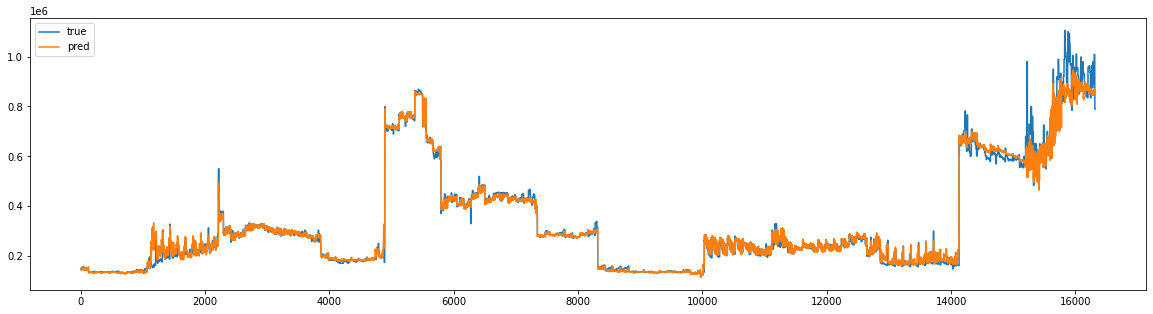

In [ ]:
valid =val_y.values

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(valid, label='true')
plt.plot(xgb_val_pred , label='pred')
plt.legend()
plt.show() #꽤잘나왔는데 ...?저 뒤에 신발종류 빼고 돌리면 되겠다.

In [ ]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(valid, xgb_val_pred))
print('MSE:', metrics.mean_squared_error(valid, xgb_val_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(valid, xgb_val_pred)))

MAE: 16544.129818051508
MSE: 1078180180.138562
RMSE: 32835.65409944748


In [ ]:
xgb_prediction_df = pd.DataFrame(val_df['date'], columns=['date'])
xgb_prediction_df['name'] = df_val['name']
xgb_prediction_df['size'] = df_val['size']
xgb_prediction_df['targetprice'] = val_df['targetprice']

xgb_prediction_df['pred'] = xgb_val_pred
xgb_prediction_df

,date,name,size,targetprice,pred
0,2022-06-16,(W) Nike Air Force 1 '07 Low White,220,145111.111111,147335.078125
1,2022-06-17,(W) Nike Air Force 1 '07 Low White,220,147750.000000,147705.953125
2,2022-06-17,(W) Nike Air Force 1 '07 Low White,220,147750.000000,147610.171875
3,2022-06-18,(W) Nike Air Force 1 '07 Low White,220,147666.666667,147028.703125
4,2022-06-18,(W) Nike Air Force 1 '07 Low White,220,147666.666667,145867.046875
...,...,...,...,...,...
16317,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,850494.875000
16318,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,855649.812500
16319,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,852487.000000
16320,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,846760.750000


In [ ]:
np.mean(xgb_prediction_df['targetprice']-xgb_prediction_df['pred']) # 평균 500원 차이 !!!

-501.2951542276425

In [ ]:
max(xgb_prediction_df['targetprice']-xgb_prediction_df['pred']) #뒤에 신발 없애고 브랜드별로 나눠서 해봐야겠음

443551.1875

In [ ]:
groups = xgb_prediction_df.groupby(['date','name','size'])
targetmean = groups.mean()['targetprice']
predmean = groups.mean()['pred']

groupdata = pd.DataFrame([targetmean, predmean]).transpose()
groupdata.columns=['target','prediction']
groupdata #최종!! 날짜별 신발들의 사이즈별 평균 예측

target  \
date       name                                              size                  
2022-06-16 (W) Nike Air Force 1 '07 Low White                220   145111.111111   
                                                             225   135666.666667   
                                                             230   135878.787879   
                                                             235   136315.789474   
                                                             240   138157.894737   
...                                                                          ...   
2022-07-02 Nike x Tom Sachs General Purpose Shoe Light Cream 270   971000.000000   
                                                             275   924800.000000   
                                                             280   886500.000000   
                                                             285   938500.000000   
                                                             295   890000.000000   

                                                                      prediction  
date       name                                              size                 
2022-06-16 (W) Nike Air Force 1 '07 Low White                220   147335.078125  
                                                             225   133259.843750  
                                                             230   134348.062500  
                                                             235   134887.984375  
                                                             240   136450.000000  
...                                                                          ...  
2022-07-02 Nike x Tom Sachs General Purpose Shoe Light Cream 270   830866.625000  
                                                             275   887101.000000  
                                                             280   863366.312500  
                                                             285   855240.562500  
                                                             295   853012.250000  

[2143 rows x 2 columns]

In [ ]:
np.mean(groupdata['target']-groupdata['prediction']) # 평균 600원 차이 !!!

-620.9980589326514

In [ ]:
max(groupdata['target']-groupdata['prediction']) 

399752.4375

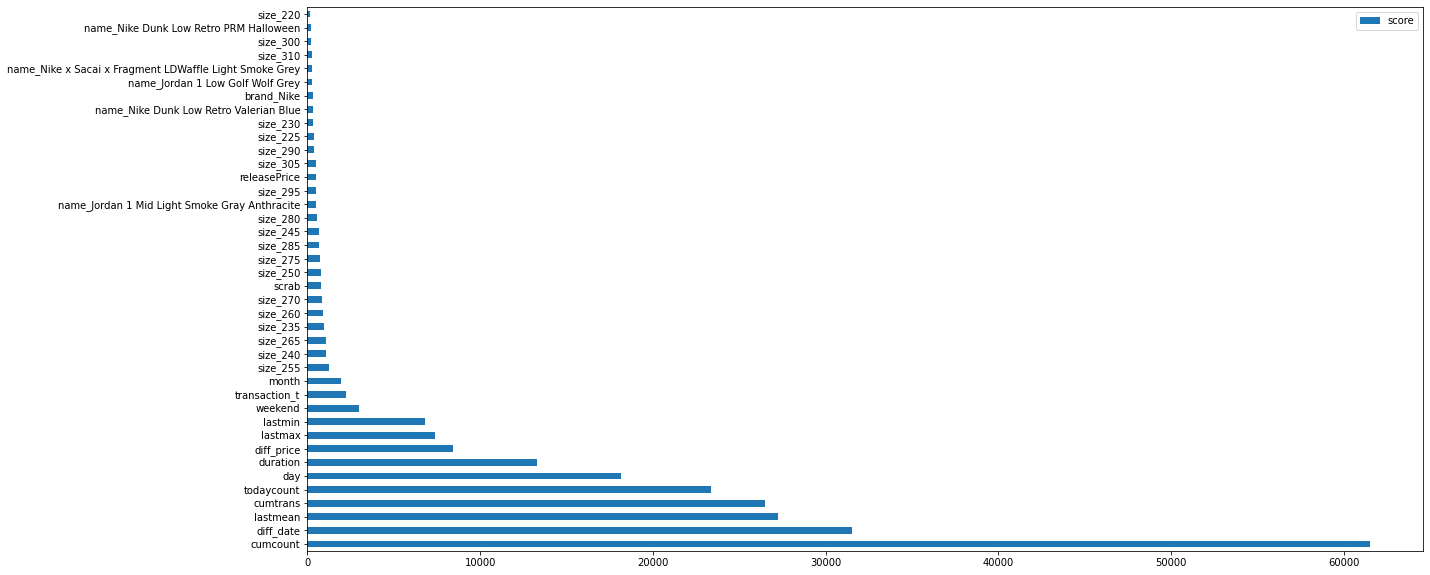

In [ ]:
feature_important = xgb_model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
data.index.values

array(['duration', 'transaction_t', 'mean', 'max', 'todaycount', 'min',
       'scrab', 'name_Nike Dunk Low Retro PRM Halloween', 'cumdate',
       'cumtrans', 'name_New Balance 993 Made in USA Grey - D Standard',
       'name_Jordan 1 Mid Light Smoke Gray Anthracite',
       'name_Jordan 1 Low Golf Wolf Grey',
       'name_Nike Dunk Low Retro Valerian Blue',
       'name_Jordan 1 Retro High OG Black Mocha',
       'name_Nike x Sacai x Fragment LDWaffle Light Smoke Grey',
       'name_New Balance 992 Made in USA Grey - D Standard',
       'brand_Jordan', 'color_WHITE', 'name_Adidas Yeezy Foam RNNR Onyx',
       'day', "name_(W) Nike Air Force 1 '07 Low White", 'brand_Nike',
       "name_Nike Air Force 1 '07 Low White", 'brand_New Balance',
       'month', 'weekend'], dtype=object)

###xgb2

In [ ]:
# training 더 늘려서
params = {
    'learning_rate': 0.02,
    'objective': 'reg:squarederror',
    'eval_metric':'mae', 
    'seed':42
}

In [ ]:
import xgboost as xgb

d_train = xgb.DMatrix(data=xgb_train, label = train_y)
d_val = xgb.DMatrix(data=xgb_val, label = val_y)
wlist = [(d_train, 'train'), (d_val,'eval')]

xgb_model = xgb.train(params, d_train, 5000, evals=wlist, verbose_eval=1000, early_stopping_rounds=100)

[0]	train-mae:334910	eval-mae:323255
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[1000]	train-mae:5783.23	eval-mae:16543.4
[2000]	train-mae:4411.75	eval-mae:15805.2
[3000]	train-mae:3589.77	eval-mae:15365.6
[4000]	train-mae:3031.82	eval-mae:15136.5
[4999]	train-mae:2610.14	eval-mae:14930.5


In [ ]:
xgb_train_pred = (xgb_model.predict(d_train))
xgb_val_pred = (xgb_model.predict(d_val))

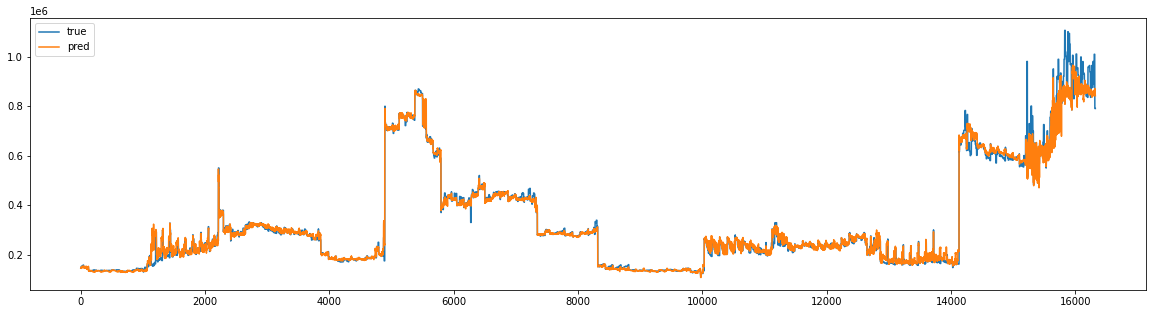

In [ ]:
valid =val_y.values

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(valid, label='true')
plt.plot(xgb_val_pred , label='pred')
plt.legend()
plt.show()

In [ ]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(valid, xgb_val_pred))
print('MSE:', metrics.mean_squared_error(valid, xgb_val_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(valid, xgb_val_pred)))

MAE: 14930.532961775292
MSE: 1057916461.6237093
RMSE: 32525.627766788904


In [ ]:
xgb_prediction_df = pd.DataFrame(val_df['date'], columns=['date'])
xgb_prediction_df['name'] = df_val['name']
xgb_prediction_df['size'] = df_val['size']
xgb_prediction_df['targetprice'] = val_df['targetprice']

xgb_prediction_df['pred'] = xgb_val_pred
xgb_prediction_df

,date,name,size,targetprice,pred
0,2022-06-16,(W) Nike Air Force 1 '07 Low White,220,145111.111111,146502.453125
1,2022-06-17,(W) Nike Air Force 1 '07 Low White,220,147750.000000,147270.296875
2,2022-06-17,(W) Nike Air Force 1 '07 Low White,220,147750.000000,147023.250000
3,2022-06-18,(W) Nike Air Force 1 '07 Low White,220,147666.666667,146813.421875
4,2022-06-18,(W) Nike Air Force 1 '07 Low White,220,147666.666667,146547.062500
...,...,...,...,...,...
16317,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,845973.625000
16318,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,852860.937500
16319,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,846306.250000
16320,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,842938.562500


In [ ]:
np.mean(xgb_prediction_df['targetprice']-xgb_prediction_df['pred']) # 평균 500원 차이 !!!

709.5775765000566

In [ ]:
max(xgb_prediction_df['targetprice']-xgb_prediction_df['pred']) #뒤에 신발 없애고 브랜드별로 나눠서 해봐야겠음

437301.5625

In [ ]:
groups = xgb_prediction_df.groupby(['date','name','size'])
targetmean = groups.mean()['targetprice']
predmean = groups.mean()['pred']

groupdata = pd.DataFrame([targetmean, predmean]).transpose()
groupdata.columns=['target','prediction']
groupdata #최종!! 날짜별 신발들의 사이즈별 평균 예측

target  \
date       name                                              size                  
2022-06-16 (W) Nike Air Force 1 '07 Low White                220   145111.111111   
                                                             225   135666.666667   
                                                             230   135878.787879   
                                                             235   136315.789474   
                                                             240   138157.894737   
...                                                                          ...   
2022-07-02 Nike x Tom Sachs General Purpose Shoe Light Cream 270   971000.000000   
                                                             275   924800.000000   
                                                             280   886500.000000   
                                                             285   938500.000000   
                                                             295   890000.000000   

                                                                      prediction  
date       name                                              size                 
2022-06-16 (W) Nike Air Force 1 '07 Low White                220   146502.453125  
                                                             225   134804.171875  
                                                             230   135776.109375  
                                                             235   135737.171875  
                                                             240   137749.203125  
...                                                                          ...  
2022-07-02 Nike x Tom Sachs General Purpose Shoe Light Cream 270   838455.500000  
                                                             275   892628.125000  
                                                             280   859146.812500  
                                                             285   849740.000000  
                                                             295   848629.375000  

[2143 rows x 2 columns]

In [ ]:
np.mean(groupdata['target']-groupdata['prediction']) # 평균 600원 차이 !!!

575.2881053230649

(array([2.200e+01, 1.540e+02, 1.896e+03, 2.800e+01, 2.900e+01, 7.000e+00,
        5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-122239.71875 ,  -70086.784375,  -17933.85    ,   34219.084375,
          86372.01875 ,  138524.953125,  190677.8875  ,  242830.821875,
         294983.75625 ,  347136.690625,  399289.625   ]),
 <a list of 10 Patch objects>)

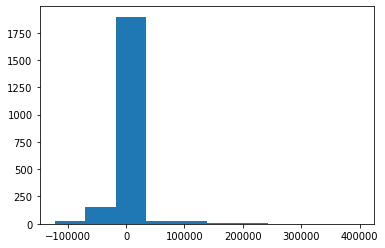

In [ ]:
plt.hist(groupdata['target']-groupdata['prediction'])

In [ ]:
max(groupdata['target']-groupdata['prediction']) 

399289.625

###xgb3

In [ ]:
# 중요도 top들로만 
xgb_train = train_df[data.index.values]
xgb_val = val_df[data.index.values]

In [ ]:
train_y = train_df['targetprice']
val_y = val_df['targetprice']

In [ ]:
params = {
    'learning_rate': 0.02,
    'objective': 'reg:squarederror',
    'eval_metric':'mae', 
    'seed':42
}

In [ ]:
import xgboost as xgb

d_train = xgb.DMatrix(data=xgb_train, label = train_y)
d_val = xgb.DMatrix(data=xgb_val, label = val_y)
wlist = [(d_train, 'train'), (d_val,'eval')]

xgb_model = xgb.train(params, d_train, 5000, evals=wlist, verbose_eval=1000, early_stopping_rounds=100)

[0]	train-mae:334910	eval-mae:323255
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[1000]	train-mae:5798.91	eval-mae:16561.5
[2000]	train-mae:4432.59	eval-mae:15923.1
[3000]	train-mae:3594.04	eval-mae:15462
[4000]	train-mae:3017.13	eval-mae:15142.1
[4999]	train-mae:2585.47	eval-mae:14996.6


In [ ]:
xgb_train_pred = (xgb_model.predict(d_train))
xgb_val_pred = (xgb_model.predict(d_val))

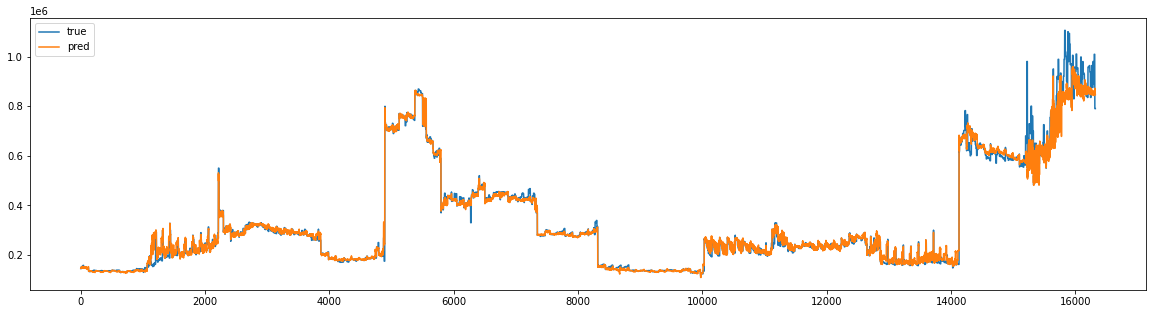

In [ ]:
valid =val_y.values

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(valid, label='true')
plt.plot(xgb_val_pred , label='pred')
plt.legend()
plt.show()

In [ ]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(valid, xgb_val_pred))
print('MSE:', metrics.mean_squared_error(valid, xgb_val_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(valid, xgb_val_pred)))

MAE: 14996.564807613673
MSE: 1057586128.3597388
RMSE: 32520.54932438471


In [ ]:
xgb_prediction_df = pd.DataFrame(val_df['date'], columns=['date'])
xgb_prediction_df['name'] = df_val['name']
xgb_prediction_df['size'] = df_val['size']
xgb_prediction_df['targetprice'] = val_df['targetprice']

xgb_prediction_df['pred'] = xgb_val_pred
xgb_prediction_df

,date,name,size,targetprice,pred
0,2022-06-16,(W) Nike Air Force 1 '07 Low White,220,145111.111111,146098.656250
1,2022-06-17,(W) Nike Air Force 1 '07 Low White,220,147750.000000,146854.921875
2,2022-06-17,(W) Nike Air Force 1 '07 Low White,220,147750.000000,146621.890625
3,2022-06-18,(W) Nike Air Force 1 '07 Low White,220,147666.666667,146168.937500
4,2022-06-18,(W) Nike Air Force 1 '07 Low White,220,147666.666667,146024.000000
...,...,...,...,...,...
16317,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,849138.875000
16318,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,853819.375000
16319,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,851773.375000
16320,2022-07-01,Nike x Tom Sachs General Purpose Shoe Light Cream,305,790000.000000,847432.500000


In [ ]:
np.mean(xgb_prediction_df['targetprice']-xgb_prediction_df['pred']) # 평균 500원 차이 !!!

831.6664462004604

In [ ]:
max(xgb_prediction_df['targetprice']-xgb_prediction_df['pred']) #뒤에 신발 없애고 브랜드별로 나눠서 해봐야겠음

427569.25

In [ ]:
groups = xgb_prediction_df.groupby(['date','name','size'])
targetmean = groups.mean()['targetprice']
predmean = groups.mean()['pred']

groupdata = pd.DataFrame([targetmean, predmean]).transpose()
groupdata.columns=['target','prediction']
groupdata #최종!! 날짜별 신발들의 사이즈별 평균 예측

target  \
date       name                                              size                  
2022-06-16 (W) Nike Air Force 1 '07 Low White                220   145111.111111   
                                                             225   135666.666667   
                                                             230   135878.787879   
                                                             235   136315.789474   
                                                             240   138157.894737   
...                                                                          ...   
2022-07-02 Nike x Tom Sachs General Purpose Shoe Light Cream 270   971000.000000   
                                                             275   924800.000000   
                                                             280   886500.000000   
                                                             285   938500.000000   
                                                             295   890000.000000   

                                                                      prediction  
date       name                                              size                 
2022-06-16 (W) Nike Air Force 1 '07 Low White                220   146098.656250  
                                                             225   134596.015625  
                                                             230   135609.359375  
                                                             235   135813.140625  
                                                             240   137896.296875  
...                                                                          ...  
2022-07-02 Nike x Tom Sachs General Purpose Shoe Light Cream 270   844320.437500  
                                                             275   900962.312500  
                                                             280   857844.625000  
                                                             285   852590.625000  
                                                             295   847476.500000  

[2143 rows x 2 columns]

In [ ]:
np.mean(groupdata['target']-groupdata['prediction']) # 평균 600원 차이 !!!

671.4604578953935

(array([2.900e+01, 2.150e+02, 1.831e+03, 2.800e+01, 2.200e+01, 1.100e+01,
        4.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([-116607.1875 ,  -65430.21875,  -14253.25   ,   36923.71875,
          88100.6875 ,  139277.65625,  190454.625  ,  241631.59375,
         292808.5625 ,  343985.53125,  395162.5    ]),
 <a list of 10 Patch objects>)

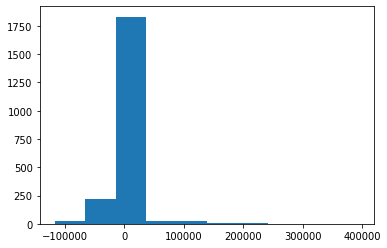

In [ ]:
plt.hist(groupdata['target']-groupdata['prediction'])

In [ ]:
max(groupdata['target']-groupdata['prediction']) 

395162.5

### xgb w/ optuna tuning

**0단계: 파라미터 고정**

In [ ]:
dtrain = xgb.DMatrix(data=xgb_train, label = train_y)
dval_x = xgb.DMatrix(xgb_val)

In [ ]:
param = {
	'eta': 0.05,
  'num_boost_rounds': 3000,
	'eval_metric': 'mae',
	'seed': 1,
  'max_depth': 5,
	'min_child_weight': 1,
  'gamma': 0,
  'sub_sample': 0.8,
  'colsample_bytree': 0.8,
}

model = xgb.train(param, dtrain)

In [ ]:
preds = model.predict(dval_x)
score = metrics.mean_absolute_error(val_y, preds)
score

112311.54758301866

**1단계: max_depth & min_child_weight 튜닝**

In [ ]:
def objectiveXGB(trial, train_x = xgb_train, train_y = train_y, val_x = xgb_val, val_y = val_y):
		param = {
			'eta': 0.05,
  		'num_boost_rounds': 3000,
			'eval_metric': 'mae',
			'seed': 1,
			'max_depth': trial.suggest_int('max_depth', 3 ,18),
			'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
			'gamma': 0,
			'sub_sample': 0.8,
			'colsample_bytree': 0.8
		}

		dtrain = xgb.DMatrix(data=xgb_train, label = train_y)
		dval_x = xgb.DMatrix(xgb_val)

		model = xgb.train(param, dtrain)

		preds = model.predict(dval_x)
		
		score = metrics.mean_absolute_error(val_y, preds)
 
		return score

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna import Trial, visualization

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objectiveXGB, n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-07-08 02:38:55,958] A new study created in memory with name: no-name-1df3ae0e-6d1a-446a-af6a-71ab8f0035da
[I 2022-07-08 02:38:56,072] Trial 0 finished with value: 111469.28146865281 and parameters: {'max_depth': 3, 'min_child_weight': 63}. Best is trial 0 with value: 111469.28146865281.
[I 2022-07-08 02:38:56,239] Trial 1 finished with value: 113108.0981612339 and parameters: {'max_depth': 10, 'min_child_weight': 176}. Best is trial 0 with value: 111469.28146865281.
[I 2022-07-08 02:38:56,363] Trial 2 finished with value: 111912.7408981425 and parameters: {'max_depth': 4, 'min_child_weight': 279}. Best is trial 0 with value: 111469.28146865281.
[I 2022-07-08 02:38:56,534] Trial 3 finished with value: 113159.70919868947 and parameters: {'max_depth': 17, 'min_child_weight': 253}. Best is trial 0 with value: 111469.28146865281.
[I 2022-07-08 02:38:56,706] Trial 4 finished with value: 113268.02369953632 and parameters: {'max_depth': 11, 'min_child_weight': 69}. Best is trial 0 with

Best trial: score 111469.20284908096,
params {'max_depth': 3, 'min_child_weight': 35}


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study)

*   두 파라미터 중요도 차이가 너무 많이 나서 min_child_weight 다시 튜닝

In [ ]:
def objectiveXGB(trial, train_x = xgb_train, train_y = train_y, val_x = xgb_val, val_y = val_y):
		param = {
			'eta': 0.05,
  		'num_boost_rounds': 3000,
			'eval_metric': 'mae',
			'seed': 1,
			'max_depth': 3,
			'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
			'gamma': 0,
			'sub_sample': 0.8,
			'colsample_bytree': 0.8
		}

		dtrain = xgb.DMatrix(data=xgb_train, label = train_y)
		dval_x = xgb.DMatrix(xgb_val)

		model = xgb.train(param, dtrain)

		preds = model.predict(dval_x)
		
		score = metrics.mean_absolute_error(val_y, preds)
 
		return score

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objectiveXGB, n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-07-08 02:41:16,765] A new study created in memory with name: no-name-90af39a2-ff75-4022-9e24-07dee47d8a24
[I 2022-07-08 02:41:16,994] Trial 0 finished with value: 111469.428267992 and parameters: {'min_child_weight': 164}. Best is trial 0 with value: 111469.428267992.
[I 2022-07-08 02:41:17,165] Trial 1 finished with value: 111469.428267992 and parameters: {'min_child_weight': 111}. Best is trial 0 with value: 111469.428267992.
[I 2022-07-08 02:41:17,438] Trial 2 finished with value: 111469.428267992 and parameters: {'min_child_weight': 138}. Best is trial 0 with value: 111469.428267992.
[I 2022-07-08 02:41:17,631] Trial 3 finished with value: 111469.428267992 and parameters: {'min_child_weight': 160}. Best is trial 0 with value: 111469.428267992.
[I 2022-07-08 02:41:17,807] Trial 4 finished with value: 111469.428267992 and parameters: {'min_child_weight': 189}. Best is trial 0 with value: 111469.428267992.
[I 2022-07-08 02:41:17,978] Trial 5 finished with value: 111469.4282679

Best trial: score 111350.57371029543,
params {'min_child_weight': 300}


**2단계: gamma 튜닝**

In [ ]:
def objectiveXGB(trial, train_x = xgb_train, train_y = train_y, val_x = xgb_val, val_y = val_y):
		param = {
			'eta': 0.05,
  		'num_boost_rounds': 3000,
			'eval_metric': 'mae',
			'seed': 1,
			'max_depth': 3,
			'min_child_weight': 300,
			'gamma': trial.suggest_categorical('gamma', [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]),
			'sub_sample': 0.8,
			'colsample_bytree': 0.8
		}

		dtrain = xgb.DMatrix(data=xgb_train, label = train_y)
		dval_x = xgb.DMatrix(xgb_val)

		model = xgb.train(param, dtrain)

		preds = model.predict(dval_x)
		
		score = metrics.mean_absolute_error(val_y, preds)
 
		return score

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objectiveXGB, n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-07-08 02:42:23,225] A new study created in memory with name: no-name-cbb123e5-40a5-4f70-8a48-0119791194f5
[I 2022-07-08 02:42:23,487] Trial 0 finished with value: 111350.57371029543 and parameters: {'gamma': 0.5}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:42:23,705] Trial 1 finished with value: 111350.57371029543 and parameters: {'gamma': 0.5}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:42:23,952] Trial 2 finished with value: 111350.57371029543 and parameters: {'gamma': 0}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:42:24,137] Trial 3 finished with value: 111350.57371029543 and parameters: {'gamma': 0.15}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:42:24,439] Trial 4 finished with value: 111350.57371029543 and parameters: {'gamma': 0.3}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:42:24,690] Trial 5 finished with value: 111350.57371029543 and parameters: {'gamma': 0.1}.

Best trial: score 111350.57371029543,
params {'gamma': 0.5}


**3단계: sub_sample & colsample_bytree**

In [ ]:
def objectiveXGB(trial, train_x = xgb_train, train_y = train_y, val_x = xgb_val, val_y = val_y):
		param = {
			'eta': 0.05,
			'num_boost_rounds': 3000,
			'eval_metric': 'mae',
			'seed': 1,
			'max_depth': 3,
			'min_child_weight': 300,
			'gamma': 0.5,
			'sub_sample': trial.suggest_categorical('sub_sample', [0.6, 0.65, 0.7, 0.75, 0.8, 0.85]),
			'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
		}

		dtrain = xgb.DMatrix(data=xgb_train, label = train_y)
		dval_x = xgb.DMatrix(xgb_val)

		model = xgb.train(param, dtrain)

		preds = model.predict(dval_x)
		
		score = metrics.mean_absolute_error(val_y, preds)
 
		return score

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objectiveXGB, n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-07-08 02:44:24,318] A new study created in memory with name: no-name-7fccf11d-b4ee-4399-a566-ec56656d73e6
[I 2022-07-08 02:44:24,424] Trial 0 finished with value: 111435.81674811195 and parameters: {'sub_sample': 0.7, 'colsample_bytree': 0.7}. Best is trial 0 with value: 111435.81674811195.
[I 2022-07-08 02:44:24,537] Trial 1 finished with value: 111350.57371029543 and parameters: {'sub_sample': 0.75, 'colsample_bytree': 0.85}. Best is trial 1 with value: 111350.57371029543.
[I 2022-07-08 02:44:24,646] Trial 2 finished with value: 111350.57371029543 and parameters: {'sub_sample': 0.75, 'colsample_bytree': 0.8}. Best is trial 1 with value: 111350.57371029543.
[I 2022-07-08 02:44:24,747] Trial 3 finished with value: 111435.81674811195 and parameters: {'sub_sample': 0.6, 'colsample_bytree': 0.7}. Best is trial 1 with value: 111350.57371029543.
[I 2022-07-08 02:44:24,855] Trial 4 finished with value: 111483.58041911929 and parameters: {'sub_sample': 0.65, 'colsample_bytree': 0.75}.

Best trial: score 111350.57371029543,
params {'sub_sample': 0.75, 'colsample_bytree': 0.85}


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study)

**4단계: subsample 추가 튜닝**

In [ ]:
def objectiveXGB(trial, train_x = xgb_train, train_y = train_y, val_x = xgb_val, val_y = val_y):
		param = {
			'eta': 0.05,
			'num_boost_rounds': 3000,
			'eval_metric': 'mae',
			'seed': 1,
			'max_depth': 3,
			'min_child_weight': 300,
			'gamma': 0.5,
			'sub_sample': trial.suggest_categorical('sub_sample', [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]),
			'colsample_bytree': 0.85
		}

		dtrain = xgb.DMatrix(data=xgb_train, label = train_y)
		dval_x = xgb.DMatrix(xgb_val)

		model = xgb.train(param, dtrain)

		preds = model.predict(dval_x)
		
		score = metrics.mean_absolute_error(val_y, preds)
 
		return score

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objectiveXGB, n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-07-08 02:45:58,758] A new study created in memory with name: no-name-51d47f2b-10fc-4eee-8e19-905989d0f5c9
[I 2022-07-08 02:45:58,938] Trial 0 finished with value: 111350.57371029543 and parameters: {'sub_sample': 0.8}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:45:59,115] Trial 1 finished with value: 111350.57371029543 and parameters: {'sub_sample': 0.6}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:45:59,296] Trial 2 finished with value: 111350.57371029543 and parameters: {'sub_sample': 0.75}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:45:59,474] Trial 3 finished with value: 111350.57371029543 and parameters: {'sub_sample': 0.5}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:45:59,661] Trial 4 finished with value: 111350.57371029543 and parameters: {'sub_sample': 0.6}. Best is trial 0 with value: 111350.57371029543.
[I 2022-07-08 02:45:59,842] Trial 5 finished with value: 111350.57371029543 and 

Best trial: score 111350.57371029543,
params {'sub_sample': 0.8}


**5단계: alpha & lambda 튜닝**

In [ ]:
def objectiveXGB(trial, train_x = xgb_train, train_y = train_y, val_x = xgb_val, val_y = val_y):
		param = {
			'eta': 0.05,
			'num_boost_rounds': 3000,
			'eval_metric': 'mae',
			'seed': 1,
			'max_depth': 3,
			'min_child_weight': 300,
			'gamma': 0.5,
			'sub_sample': 0.8,
			'colsample_bytree': 0.85,
      'alpha': trial.suggest_categorical('alpha', [1e-5, 1e-2, 0.1, 1, 10, 20, 30, 50, 60, 70, 80, 90, 100]),
      'lamnbda': trial.suggest_categorical('lambda', [1e-5, 1e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6])                                                
		}


		dtrain = xgb.DMatrix(data=train_x, label=train_y)
		dval_x = xgb.DMatrix(val_x)

		model = xgb.train(param, dtrain)

		preds = model.predict(dval_x)
		
		score = metrics.mean_absolute_error(val_y, preds)
 
		return score

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objectiveXGB, n_trials = 50)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-07-08 02:47:59,083] A new study created in memory with name: no-name-9bfd04a9-7559-4eef-8f09-d0f92ade1aeb
[I 2022-07-08 02:47:59,219] Trial 0 finished with value: 111350.57546993003 and parameters: {'alpha': 70, 'lambda': 0.5}. Best is trial 0 with value: 111350.57546993003.
[I 2022-07-08 02:47:59,340] Trial 1 finished with value: 111350.57442178477 and parameters: {'alpha': 30, 'lambda': 0.25}. Best is trial 1 with value: 111350.57442178477.
[I 2022-07-08 02:47:59,456] Trial 2 finished with value: 111350.57371029543 and parameters: {'alpha': 0.1, 'lambda': 0.3}. Best is trial 2 with value: 111350.57371029543.
[I 2022-07-08 02:47:59,565] Trial 3 finished with value: 111350.57417189583 and parameters: {'alpha': 20, 'lambda': 0.2}. Best is trial 2 with value: 111350.57371029543.
[I 2022-07-08 02:47:59,678] Trial 4 finished with value: 111350.57371029543 and parameters: {'alpha': 1, 'lambda': 0.15}. Best is trial 2 with value: 111350.57371029543.
[I 2022-07-08 02:47:59,790] Trial 

Best trial: score 111350.57371029543,
params {'alpha': 0.1, 'lambda': 0.3}


In [ ]:
d_train = xgb.DMatrix(data=xgb_train, label = train_y)
d_val = xgb.DMatrix(data=xgb_val, label = val_y)
wlist = [(d_train, 'train'), (d_val,'eval')]

params = {
		'eta': 0.05,
		'num_boost_rounds': 3000,
		'eval_metric': 'mae',
		'seed': 1,
		'max_depth': 3,
		'min_child_weight': 300,
		'gamma': 0.5,
		'sub_sample': 0.8,
		'colsample_bytree': 0.85,
    'alpha': 0.1, 
    'lamnbda': 0.3                                               
}

model = xgb.train( params, dtrain, 500, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

[0]	train-mae:205539	eval-mae:183100
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[20]	train-mae:73715.8	eval-mae:58680
[40]	train-mae:26501.8	eval-mae:15157.3
[60]	train-mae:10651.4	eval-mae:7356.73
[80]	train-mae:7611.32	eval-mae:8261.62
[100]	train-mae:7168.83	eval-mae:8605.63
[120]	train-mae:7032.49	eval-mae:8714.84
[140]	train-mae:6967.71	eval-mae:8661.84
Stopping. Best iteration:
[58]	train-mae:11426.3	eval-mae:7311.9



In [ ]:
xgb_train_pred = (model.predict(d_train))
xgb_val_pred = (model.predict(d_val))

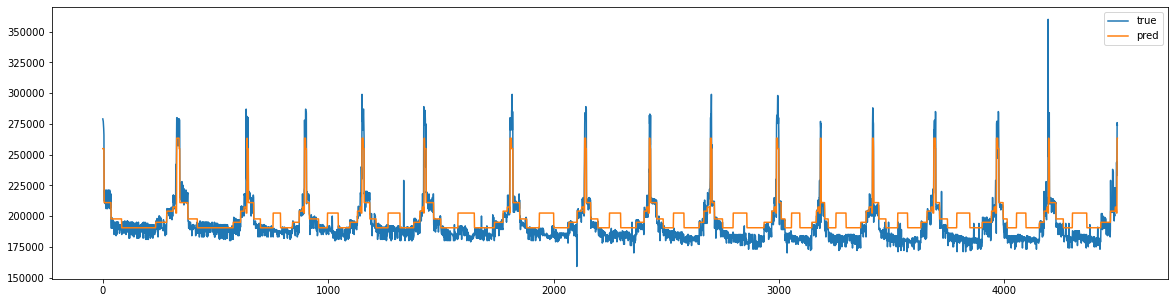

In [ ]:
valid =val_y.values

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(valid, label='true')
plt.plot(xgb_val_pred , label='pred')
plt.legend()
plt.show()

In [ ]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(valid, xgb_val_pred))

MAE: 8546.814710822968


In [ ]:
xgb_prediction_df = pd.DataFrame(val_df['체결 날짜'], columns=['체결 날짜'])
xgb_prediction_df['거래 가격'] = val_df['거래 가격']
xgb_prediction_df['예측'] = xgb_val_pred
xgb_prediction_df

,체결 날짜,거래 가격,예측
16111,2022-06-15,279000,266713.843750
16112,2022-06-15,278000,266713.843750
16113,2022-06-15,277000,266713.843750
16114,2022-06-15,274000,266713.843750
16115,2022-06-15,271000,266713.843750
...,...,...,...
20608,2022-06-30,243000,241100.390625
20609,2022-06-30,244000,241100.390625
20610,2022-06-30,233000,217119.078125
20611,2022-06-30,276000,269346.593750


In [ ]:
xgb_prediction_df = pd.DataFrame(val_df['체결 날짜'], columns=['체결 날짜'])
xgb_prediction_df['거래 가격'] = val_df['거래 가격']
xgb_prediction_df['예측'] = xgb_val_pred
xgb_prediction_df  #다른 신발 모으던지, 시계열로 가던지

,체결 날짜,거래 가격,예측
16111,2022-06-15,279000,254818.109375
16112,2022-06-15,278000,254818.109375
16113,2022-06-15,277000,254818.109375
16114,2022-06-15,274000,254818.109375
16115,2022-06-15,271000,254818.109375
...,...,...,...
20608,2022-06-30,243000,202437.609375
20609,2022-06-30,244000,202437.609375
20610,2022-06-30,233000,202437.609375
20611,2022-06-30,276000,263328.812500


In [ ]:
test_x = test[features]
test_X = xgb.DMatrix(test_x)

pred = model.predict(test_X)

### LGBM

In [ ]:
# 중요도 top들로만 
train_x = train_df[data.index.values]
val_x = val_df[data.index.values]

In [ ]:
train_y = train_df['targetprice']
val_y = val_df['targetprice']

In [ ]:
# 파라미터 !!! 
params = {
    'objective': 'regression',
'boosting_type': ['gbdt'],
 'learning_rate': 0.02,
 'max_depth': 4,
 'metric': 'mae',
 'n_estimators': 10000,
 'random_state': 42,
'num_leaves': 506, 'min_child_samples': 99, 'reg_alpha': 0.1585234458533463, 'reg_lambda': 0.6535395893689313, 'colsample_bytree': 1.0, 'subsample': 0.4}



In [ ]:
import lightgbm as lgb
ds_train = lgb.Dataset(train_x, train_y)
ds_val = lgb.Dataset(val_x, val_y)


lgbm_model = lgb.train(params, ds_train, 10000, ds_val, early_stopping_rounds=100)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[5003]	valid_0's l1: 4340.65
[5004]	valid_0's l1: 4340.56
[5005]	valid_0's l1: 4340.39
[5006]	valid_0's l1: 4340.36
[5007]	valid_0's l1: 4340.13
[5008]	valid_0's l1: 4339.99
[5009]	valid_0's l1: 4339.71
[5010]	valid_0's l1: 4339.33
[5011]	valid_0's l1: 4339.13
[5012]	valid_0's l1: 4338.73
[5013]	valid_0's l1: 4338.53
[5014]	valid_0's l1: 4338.39
[5015]	valid_0's l1: 4337.8
[5016]	valid_0's l1: 4337.79
[5017]	valid_0's l1: 4337.51
[5018]	valid_0's l1: 4337.31
[5019]	valid_0's l1: 4336.82
[5020]	valid_0's l1: 4336.34
[5021]	valid_0's l1: 4335.87
[5022]	valid_0's l1: 4335.38
[5023]	valid_0's l1: 4335.03
[5024]	valid_0's l1: 4334.86
[5025]	valid_0's l1: 4334.6
[5026]	valid_0's l1: 4334.41
[5027]	valid_0's l1: 4334.11
[5028]	valid_0's l1: 4333.83
[5029]	valid_0's l1: 4333.25
[5030]	valid_0's l1: 4332.88
[5031]	valid_0's l1: 4332.33
[5032]	valid_0's l1: 4331.87
[5033]	valid_0's l1: 4331.59
[5034]	valid_0's l1: 4331.11
[5035]	valid_0's l1: 4330.65
[5036]	va

In [ ]:
y_val_lgbm_pred = lgbm_model.predict(val_x)

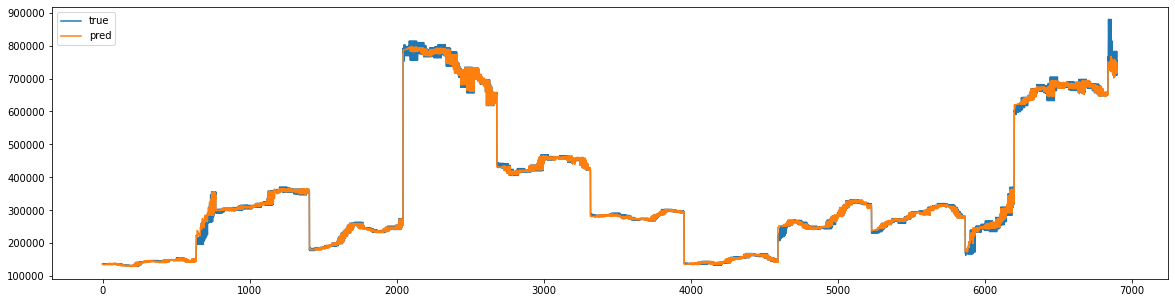

In [ ]:
valid =val_y.values

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(valid, label='true')
plt.plot(y_val_lgbm_pred , label='pred')
plt.legend()
plt.show()

In [ ]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(valid, y_val_lgbm_pred))
print('MSE:', metrics.mean_squared_error(valid, y_val_lgbm_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(valid, y_val_lgbm_pred))) #더 안좋음

MAE: 3497.8208589238284
MSE: 61786233.61207187
RMSE: 7860.421974173643


In [ ]:
lgm_prediction_df = pd.DataFrame(val_df['date'], columns=['date'])
lgm_prediction_df['targetprice'] = val_df['targetprice']
lgm_prediction_df['pred'] =y_val_lgbm_pred
lgm_prediction_df

,date,targetprice,pred
0,2022-03-30,136755.555556,135955.515253
1,2022-03-30,136793.548387,135955.515253
2,2022-03-30,137238.709677,135955.515253
3,2022-03-30,137717.791411,135955.515253
4,2022-03-30,137429.577465,135955.515253
...,...,...,...
6894,2022-06-29,754529.411765,722890.253085
6895,2022-06-29,782285.714286,749873.862610
6896,2022-06-30,711428.571429,720648.826595
6897,2022-06-30,754529.411765,727432.548690


In [ ]:
np.mean(lgm_prediction_df['targetprice']-lgm_prediction_df['pred']) #200원 차이 

-273.34550189643005